In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go

vaccin_kommun = pd.read_excel("../data/vaccine.xlsx", sheet_name="Vaccinerade kommun")
vaccin_tidsserie = pd.read_excel("../Data/vaccine.xlsx", sheet_name="Vaccinationer tidsserie")

# KPI 1
- Jämföra könen i antal intensivvårdade, dödsfall och covid-fall
- Det finns 1.33% fler män i Sverige jämfört med kvinnor
- Kommer då skillnaden vara detsamma (eller nära) för intensivvårdade, dödsfall och covid-fall?

In [2]:
Kön_uppdelning = pd.read_excel("../Data/Covid19.xlsx", sheet_name="Totalt antal per kön")
Kön_uppdelning.drop(Kön_uppdelning.tail(1).index, inplace=True) # remove last row since its 'unknown' and statistically insignificant

In [3]:
def log_plotly_bar_with_df_title_labels(df, y, x, title, labels, save_file):
    fig = px.bar(
        df,
        y=y,
        x=x,
        barmode="group",  # groups the bars next to eachother instead of stacking on eachother
        labels=labels,
        title=title,
        log_y=True,  # easier to read, makes y-axes logarithmic
    )

    fig.show()
    fig.write_html("../Labb_1/Visualiseringar/" + save_file + ".html")


labels_antal_fall_kön = {"value": "Befolkning", "variable": "Antal fall av Covid-19"}

log_plotly_bar_with_df_title_labels(
    Kön_uppdelning,
    ["Totalt_antal_fall", "Totalt_antal_intensivvårdade", "Totalt_antal_avlidna"],
    "Kön",
    "Antal fall per kön",
    labels_antal_fall_kön,
    "KPI_1_Antal_fall_per_kön-",
)


- Som vi kan se så är skillnaden större på alla jämförelser än 1.33%
* Antal fall har en skillnad på 14.13% (Män har den högre siffran)
* Antal intenssivvårdade har en skillnad på 55% (Män har den högre siffran)
* Antal avlidna har en skillnad på 17.78% (Män har den högre siffran)

- Som vi då kan se så har män utan tvekan större risk på alla fronter, speciellt intensivvård.
- Varför siffran är såpass stor på intensivvården hade varit intressant att utforska

# KPI 2
- Jämföra antal kumulativ fall, avlidna och intensivvårdade
- Kommer troligtvis ligga relativt nära varandra

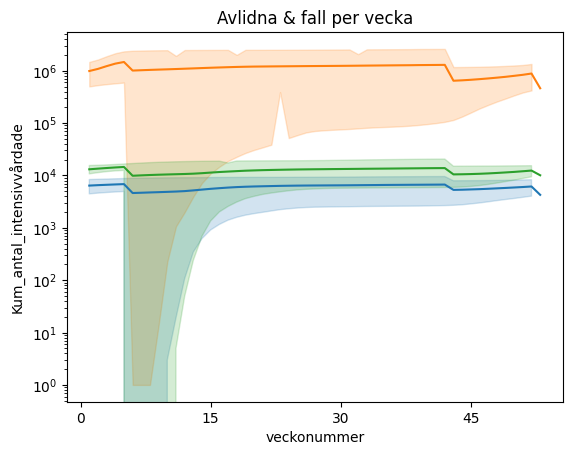

In [4]:
covid_stats = pd.read_excel("../Data/Covid19.xlsx", sheet_name="Veckodata Riket")

weeknumbers = covid_stats['veckonummer']
kum_intensiv = covid_stats['Kum_antal_intensivvårdade']
kum_fall = covid_stats['Kum_antal_fall']
kum_avlidna = covid_stats['Kum_antal_avlidna']

# didnt make a function out of this since its a one-off
ax = plt.axes()
sns.lineplot(x = weeknumbers, y = kum_intensiv, ax = ax)
sns.lineplot(x = weeknumbers, y = kum_fall, ax = ax)
sns.lineplot(x = weeknumbers, y = kum_avlidna, ax = ax)
ax.set(title = "Avlidna & fall per vecka")
ax.set_yscale("log") # y-axis set to logarithmic which makes it easier to compare and read
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig("../Labb_1/Visualiseringar/KPI_2_kum_fall_intensivv_fall")

- Följer varandra perfekt, vilket såklart känns självklart


# KPI 3
- Jämföra hur många fall per 100_000 invånare i varje län
- Jämföra och se ifall om man kan dra slutsatser på vart i landet risken för fall är högst.
- Kolla om antal fall per 100_000 ser annorlunda ut mer söder ut eller norr.

In [5]:
import json
import numpy as np
df_region = pd.read_excel("../Data/Covid19.xlsx", sheet_name="Totalt antal per region")
# needed to download a freely available json file in order to map out the different provinces

# the keys on the geojson files for some reason didn't match up correctly on the map,
# so i had to use: df_region.insert(1, "id", np.arange(21)) so i could mouseover all provinces
# and see their actually id-key, then insert them in the correct order in a new column (this took god damn forever to figure out)
df_region.insert(1, "id", [18, 3, 15, 0, 9, 11, 1, 2, 4, 12, 20, 16, 7, 17, 10, 14, 13, 8, 19, 5, 6])

- För denna KPI behövde jag använda mig utav dessa resurser för att kunna få kartan att mapa korrekt.
- https://www.youtube.com/watch?v=aJmaw3QKMvk&t=687s
- https://community.plotly.com/t/choropleth-map-error-empty-map/39521

In [6]:
with open("../Data/swedish_regions.geojson.txt", "r") as fp:
    jdata = json.load(fp)

# needed for-loop for maping out id's correctly, otherwise we'll get an empty map.
for k in range(len(jdata['features'])):
    jdata['features'][k]['id'] = k

# same with this as above KPI
fig = px.choropleth_mapbox(
    df_region, # dataframe
    geojson=jdata, # geojson file name
    locations='id', # keys for the provinces
    color="Fall_per_100000_inv", # df column
    color_continuous_scale="hot_r",
    range_color=(17300, 32500),
    mapbox_style="carto-positron",
    zoom=3,
    center={"lat": 58.6952, "lon": 11.9149}, # when the map loads in, starts at northern europe (with Sweden in the middle)
    opacity=0.7,
    labels={"Fall_per_100000_inv": "Fall per 100,000 inv"},
)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0}) # the entire window shows the map, instead of having frames around the map
print(f"Sverige medelvärde per län: {df_region['Fall_per_100000_inv'].mean():.0f}")
print(f"Sverige medianvärde per län: {df_region['Fall_per_100000_inv'].median():.0f}")
fig.show()
fig.write_html("../Labb_1/Visualiseringar/KPI_3_Fall_per_100000_inv.html")

Sverige medelvärde per län: 24763
Sverige medianvärde per län: 24999


- Jag hade förväntat mig att se framförallt: Stockholm-, Västra Götaland-, och Skåne-regionerna ha högst fall per 100,000.
- Det verkar dock inte som att det stämde överens med resultatet, vilket är förvånande.
- Jag hade behövt göra mera research för att kunna lista ut varför siffrorna är högst i just Örebro och Halland.
- Var väldigt coolt att kunna mapa ut länen på detta viset och hoppas att jag kommer jobba med det igen framöver.
--------------------------------------------------------------------------------------------------------------------------
- När det kommer till jämförelsen av norra och södra Sverige, så är det inte helt klart om vilken del som har högst fall per 100,000.
- Medans norra delen har låga siffror i: Norrbotten, Västerbotten och Västernorrland, så har södra Sverige också låga siffror i åtminstone 3 län: Blekinge, Gotland & Östergötland
- Precis som i tidigare frågeställning så hade det behövs göra mera research kring detta för att kunna dra någon slutsats.
-------------------------------
- Sverige medelvärde per län: 24763
- Sverige medianvärde per län: 24999
- Störst skilland: Örebro(32.379k) och Norrbotten (20.327k). En skillnad på 37.22%
- Skillnad mellan minst antal fall (Norrbotten) per 100k och Västra Götaland: 20.7%
- Skillnad mellan högst antal fall (Örebro) per 100k och Västra Götaland: 26.3%
- Skillnad mellan medelvärde och Västra Götaland: 3.4%
- Skillnad mellan median och Västra Götaland: 2.48%
-------------------------------------
- Vad som mer hade kunnat varit intressant att utforska är hur det kan vara en sådan stor skillnad på antal fall per 100k mellan två län som Örebro och Norrbotten (37.22%)).

# KPI 4
- Jämföra dem 5 högsta och 5 lägsta andel vaccinerade med dos 3 per kommun
- Jag förväntar mig en skillnad, dock inte jätte stor, även fast det finns många kommuner av olika storlekar i Sverige.
- Jag vill även undersöka ifall man kan se en koppling kring vart dessa kommuner befinner sig i Sverige

In [7]:
vaccin_kommun_dos3 = pd.read_excel("../Data/vaccine.xlsx", sheet_name="Vaccinerade kommun dos 3")

# Creates two dataframes with the top 5 and last 5 municipalaties
# concatinates them so we can plot
sorterad_vaccin_kommun_dos3 = vaccin_kommun_dos3.sort_values("Andel_dos3")
sorterad_vaccin_kommun_dos3 = sorterad_vaccin_kommun_dos3[["KnNamn", "Andel_dos3"]]
sorterad_vaccin_kommun_dos3_last10 = sorterad_vaccin_kommun_dos3.head(5)
sorterad_vaccin_kommun_dos3_top10 = sorterad_vaccin_kommun_dos3.tail(5)
concat_sorted_df = pd.concat([sorterad_vaccin_kommun_dos3_last10, sorterad_vaccin_kommun_dos3_top10], axis=0)

kommun_labels = {"value": "Befolkning", "variable": "Antal fall av Covid-19"}

log_plotly_bar_with_df_title_labels(
    concat_sorted_df,
    "Andel_dos3",
    "KnNamn",
    "5 lägsta andel med dos 3 per kommun & 5 högsta andel med dos 3 per kommun",
    kommun_labels,
    "KPI_4_Lägsta_och_högsta_andel_dos_3_per_kommun",
)


- Vad som är intressant här är att skillnaden kan vara såpass stora i olika kommuner, där den lägsta andelen ligger på 44% och högsta andelen ligger på 80%
- Jag hade definitvt förväntat mig att det var en skillnad på kanske 15-20% men inte 36% skillnad.

* Top 5
- Vadstena - Östergötland
- Hammarö - Värmland
- Lomma - Skåne
- Mörbylånga - Öland
- Borgholm - Öland

* Low 5
- Botkyrka - Stockholm
- Södertälje - Stockholm
- Åstorp - Skåne (nordvästra delen)
- Sigtuna - Stockholm
- Malmö - Skåne
----------------------------------
- Vad som är intressant att tillägga här är att alla kommuner där siffrorna är lägst, deras har INTE högst antal per 100k invånare som vi såg tidigare.